In [3]:
# The standard Python science stack
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from tqdm import tqdm
# For projections (wrapped for Proj)
import pyproj

# Plotting maps using GMT
import pygmt

# The Fatiando stack
import harmonica as hm

from grav_column_der import grav_column_der


e_inv = -1060000
w_inv = 900000
n_inv = -1900000
s_inv = 60000
inv_reg = [e_inv, w_inv, n_inv, s_inv]

inv_height = 80
inv_width = inv_height*(w_inv-e_inv)/(s_inv-n_inv)
inv_ratio = (s_inv-n_inv)/(inv_height/1000)
inv_proj = f"x1:{inv_ratio}"

buffer = 400e3
e_fig = e_inv+buffer
w_fig = w_inv-buffer
n_fig = n_inv+buffer
s_fig = s_inv-buffer
fig_reg = [e_fig, w_fig, n_fig, s_fig]

fig_height = 80
fig_width = fig_height*(w_fig-e_fig)/(s_fig-n_fig)
fig_ratio = (s_fig-n_fig)/(fig_height/1000)
fig_proj = f"x1:{fig_ratio}"

In [6]:
inv_region="-1060000/900000/-1900000/60000"
!gmt grdsample -R{inv_region} -rg -I40e3  ../gravity_data/ant4d_gravity.nc -G../inversion_layers/gravity_inv.nc
!gmt grdsample -R{inv_region} -rg -I40e3  ../inversion_layers/bedmachine/BedMachine_surface_5k_filled.nc -G../inversion_layers/BedMachine_surface_filled_inv.nc
!gmt grdsample -R{inv_region} -rg -I40e3  ../inversion_layers/bedmachine/BedMachine_icebase_5k_filled.nc -G../inversion_layers/BedMachine_icebase_filled_inv.nc
!gmt grdsample -R{inv_region} -rg -I40e3  ../inversion_layers/bedmachine/BedMachine_bed_5k.nc -G../inversion_layers/BedMachine_bed_inv.nc 
# !gmt grdsample -R{inv_region} -rg -I40e3  ../inversion_layers/RE_basement_BedMachinebed_filled.nc -G../inversion_layers/ROSETTA_basement_BedMachine_bed_inv.nc 
!gmt grdsample -R{inv_region} -rg -I40e3  ../inversion_layers/ANTASed_mag_basement_filled.nc -G../inversion_layers/ROSETTA_basement_BedMachine_bed_inv.nc 

grdsample [WARNING]: Output sampling interval in x exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in y exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in x exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in y exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in x exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in y exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in x exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in y exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in x exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in y exceeds input interval and may lead to aliasing.


Import data and save properties as variables

In [7]:
layers_list =[
             'ice',
             'water',
             'layer1',
            #  'layer2',
             ]
spacing_list = [
                40e3,
                40e3,
                40e3,
                # 40e3,
                ]
rho_list = [
            920,
            1030,
            2600,
            # 2800,
            ]

fname_list=[
            'C:/Users/matthewt/Documents/Python_Scripts/RIS_gravity_inversion/inversion_layers/BedMachine_surface_filled_inv.nc',
            'C:/Users/matthewt/Documents/Python_Scripts/RIS_gravity_inversion/inversion_layers/BedMachine_icebase_filled_inv.nc',
            'C:/Users/matthewt/Documents/Python_Scripts/RIS_gravity_inversion/inversion_layers/BedMachine_bed_inv.nc',
            # 'C:/Users/matthewt/Documents/Python_Scripts/RIS_gravity_inversion/inversion_layers/ROSETTA_basement_BedMachine_bed_inv.nc',
            ]

layers = {j:{'spacing':spacing_list[i], 
            'fname':fname_list[i], 
            'rho':rho_list[i]} for i, j in enumerate(layers_list)}

for k, v in layers.items():
    v['grid']=xr.load_dataset(v['fname'])
    v['df']=xr.load_dataset(v['fname']).to_dataframe().reset_index()
    v['df']['rho']=v['rho']
    v['len']=len(v['df'].x)  

fname='C:/Users/matthewt/Documents/Python_Scripts/RIS_gravity_inversion/inversion_layers/gravity_inv.nc'
grav_spacing = 40e3
grid_grav = xr.load_dataset(fname)           
df_grav = xr.load_dataset(fname).to_dataframe().reset_index() 
df_grav.rename(columns={'z':'Gobs'}, inplace=True)
df_grav.dropna(how='any', inplace=True)
df_grav['z']=layers['ice']['grid'].to_dataframe().reset_index().z+750


for k, v in layers.items():
    print(f"points in {k} file: {v['len']}") 

print(f'points in gravity file: {len(df_grav)}')    

points in ice file: 2500
points in water file: 2500
points in layer1 file: 2500
points in gravity file: 2500


psconvert [ERROR]: Registry registered C:\Program Files (x86)\GPLGS\gswin32c.exe does not exist. Resorting to the one provided in GMT.


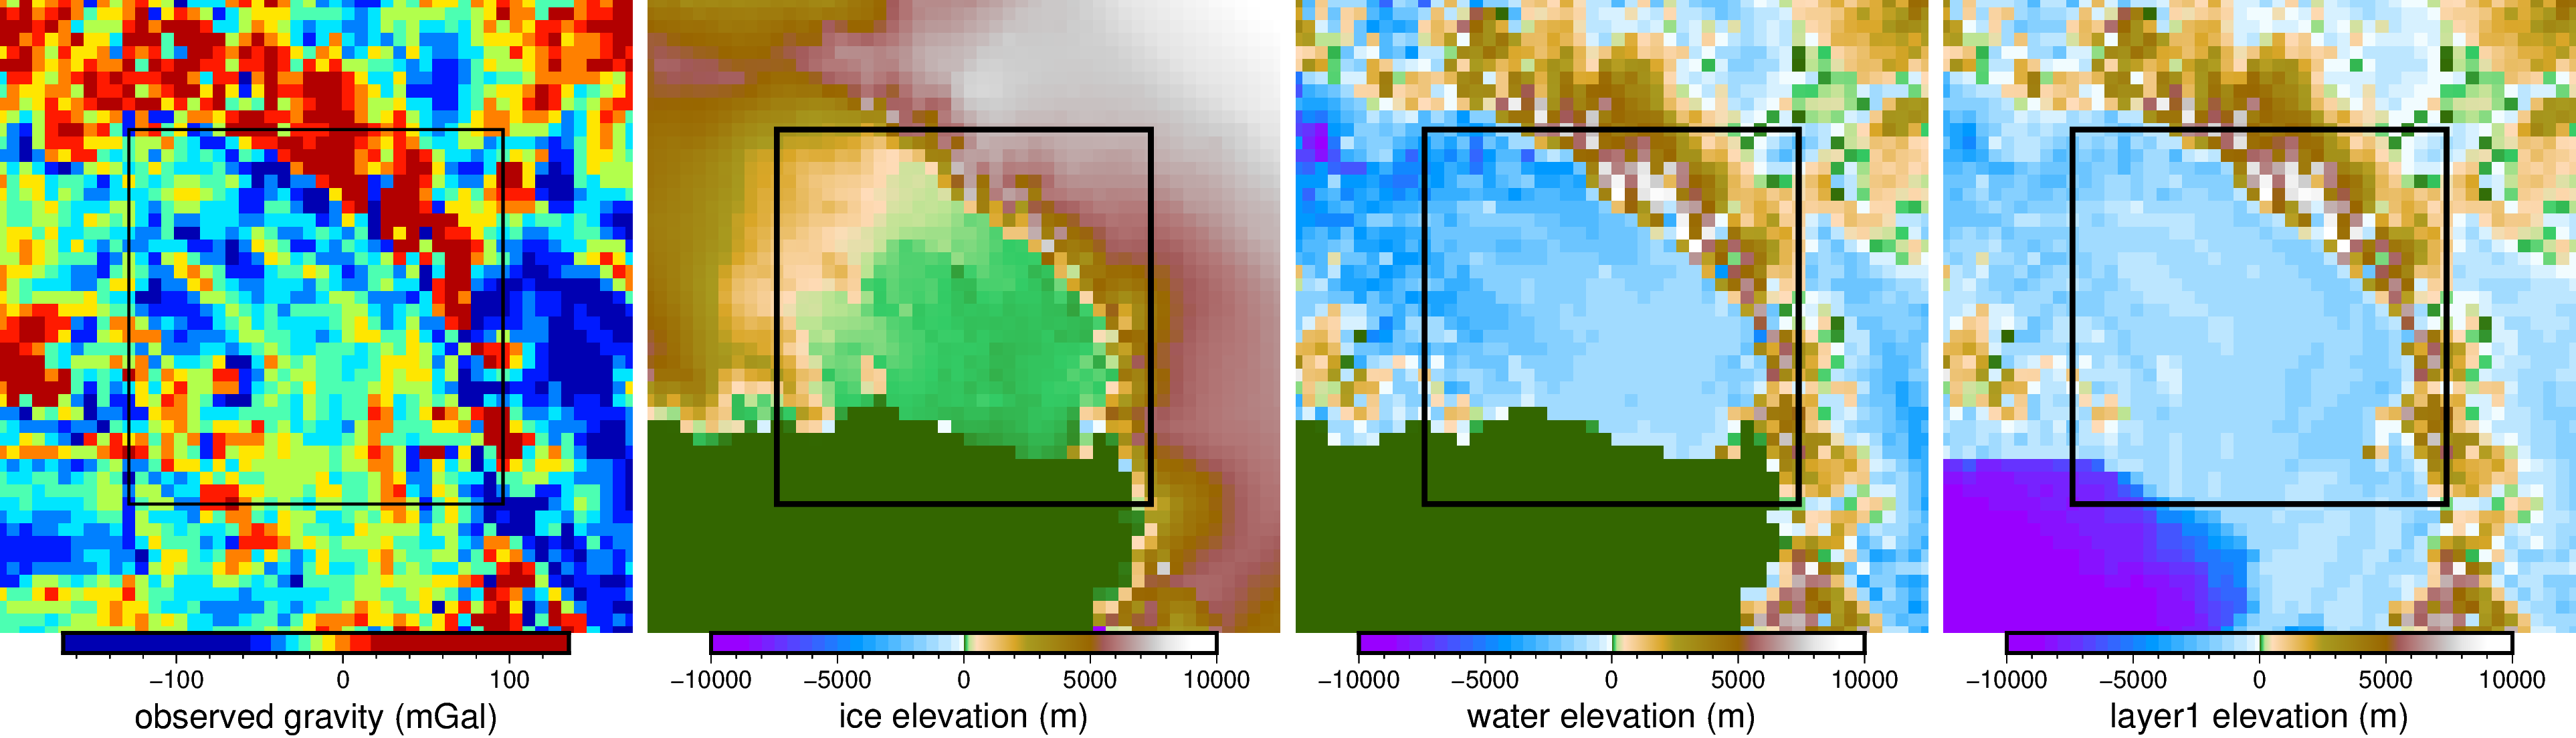

In [8]:
fig = pygmt.Figure()

pygmt.grd2cpt(cmap="jet", grid=grid_grav.z, region=fig_reg, background=True)
fig.grdimage(
    grid_grav.z,
    cmap=True,
    projection=inv_proj, 
    region=inv_reg,
    nan_transparent=True,
    frame=['+gwhite'])
fig.colorbar(cmap=True, position='jBC+jTC+h', frame='x+l"observed gravity (mGal)"')
# plot later figure extents (without inv buffer)
fig.plot(x = [e_fig, e_fig, w_fig, w_fig, e_fig], 
             y = [n_fig, s_fig, s_fig, n_fig, n_fig], 
             pen = '1p,black')

fig.shift_origin(xshift=(inv_width+2)/10)

for i, (k, v) in enumerate(layers.items()):
    data=layers[k]['grid'].z
    fig.grdimage(
        data,
        cmap='globe',
        projection=inv_proj, 
        region=inv_reg,
        nan_transparent=True,
        frame=['+gwhite'])
    fig.colorbar(cmap='globe', position='jBC+jTC+h', frame=f'x+l"{k} elevation (m)"')

    # plot later figure extents (without inv buffer)
    fig.plot(x = [e_fig, e_fig, w_fig, w_fig, e_fig], 
             y = [n_fig, s_fig, s_fig, n_fig, n_fig], 
             pen = '2p,black')
             
    fig.shift_origin(xshift=(inv_width+2)/10)
    # if i+1 == len(layers)//2:
    #     fig.shift_origin(yshift=(-inv_height-15)/10, xshift=((-inv_width-2)*1.5)/10)
    # else:
    #     fig.shift_origin(xshift=(inv_width+2)/10)
fig.show()

In [9]:
# Calculate inital forward gravity model of input layer
# add density variable to datasets
for k ,v in layers.items():
    v['grid']['density']=v['grid'].z.copy()
    v['grid'].density.values[:] = v['rho']

# list of layers, bottom up
reversed_layers_list = np.flip(layers_list[:])

for i, j in enumerate(reversed_layers_list):
    if i == 0:
        layers[j]['prisms']=hm.prism_layer(
            coordinates=(list(layers[j]['grid'].x), list(layers[j]['grid'].y)),   
            surface=layers[j]['grid'].z, 
            reference=-50e3,
            properties={'density':layers[j]['grid'].density})
    else:
        if layers[j]['spacing'] != layers[reversed_layers_list[i-1]]['spacing']:
            print(f"resolutions don't match for {j} ({layers[j]['spacing']}m) and {reversed_layers_list[i-1]} ({layers[reversed_layers_list[i-1]]['spacing']}m)")
            print(f"resampling {reversed_layers_list[i-1]} to match {j}")
            tmp = layers[j]['grid'].z.to_dataframe().reset_index()
            tmp_regrid = pygmt.grdtrack(points=tmp[['x','y']], grid=layers[reversed_layers_list[i-1]]['grid'].z, newcolname='z_regrid')
            tmp['z_low']=tmp.merge(tmp_regrid, how='left', on=['x','y']).z_regrid
            tmp_grd = pygmt.xyz2grd(tmp[['x','y','z_low']], region=inv_reg, spacing=layers[j]['spacing'])
            layers[j]['prisms']=hm.prism_layer(
                coordinates=(list(layers[j]['grid'].x), list(layers[j]['grid'].y)),   
                surface=layers[j]['grid'].z, 
                reference=tmp_grd,
                properties={'density':layers[j]['grid'].density})
        else:
            layers[j]['prisms']=hm.prism_layer(
                coordinates=(list(layers[j]['grid'].x), list(layers[j]['grid'].y)),   
                surface=layers[j]['grid'].z, 
                reference=layers[reversed_layers_list[i-1]]['grid'].z,
                properties={'density':layers[j]['grid'].density})

print('starting forward gravity calculations')
for k, v in layers.items():
    df_grav[f'{k}_forward_grav'] = v['prisms'].prism_layer.gravity(
        coordinates=(df_grav.x, df_grav.y, df_grav.z),
        field = 'g_z',)
    print(f'finished {k} layer')

# add gravity effects of all input layers
for i, j in enumerate(layers_list):
    if i == 0:
        df_grav['forward_grav_total'] = df_grav[f'{j}_forward_grav']
    else:
        df_grav['forward_grav_total'] += df_grav[f'{j}_forward_grav']

df_grav.describe()


starting forward gravity calculations
finished ice layer
finished water layer
finished layer1 layer


,x,y,Gobs,z,ice_forward_grav,water_forward_grav,layer1_forward_grav,forward_grav_total
count,2.500000e+03,2.500000e+03,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000
mean,-8.000000e+04,-9.200000e+05,-19.352316,2016.322021,48.159062,23.063188,4990.401620,5061.623871
std,5.773503e+05,5.773503e+05,26.597717,1199.770874,44.141659,51.011128,438.544140,414.266514
min,-1.060000e+06,-1.900000e+06,-167.969986,539.168945,-0.091868,0.009446,2659.352738,2843.750459
25%,-5.800000e+05,-1.420000e+06,-34.635001,778.450882,0.979623,0.027524,4876.386881,4991.392146
50%,-8.000000e+04,-9.200000e+05,-21.325000,1906.190552,38.291151,0.086302,5172.785247,5234.319094
75%,4.200000e+05,-4.200000e+05,-5.937500,3124.483948,90.996552,16.714658,5247.862749,5282.508825
max,9.000000e+05,6.000000e+04,135.619995,4798.599609,148.989108,185.353481,5613.781201,5615.536414


psconvert [ERROR]: Registry registered C:\Program Files (x86)\GPLGS\gswin32c.exe does not exist. Resorting to the one provided in GMT.


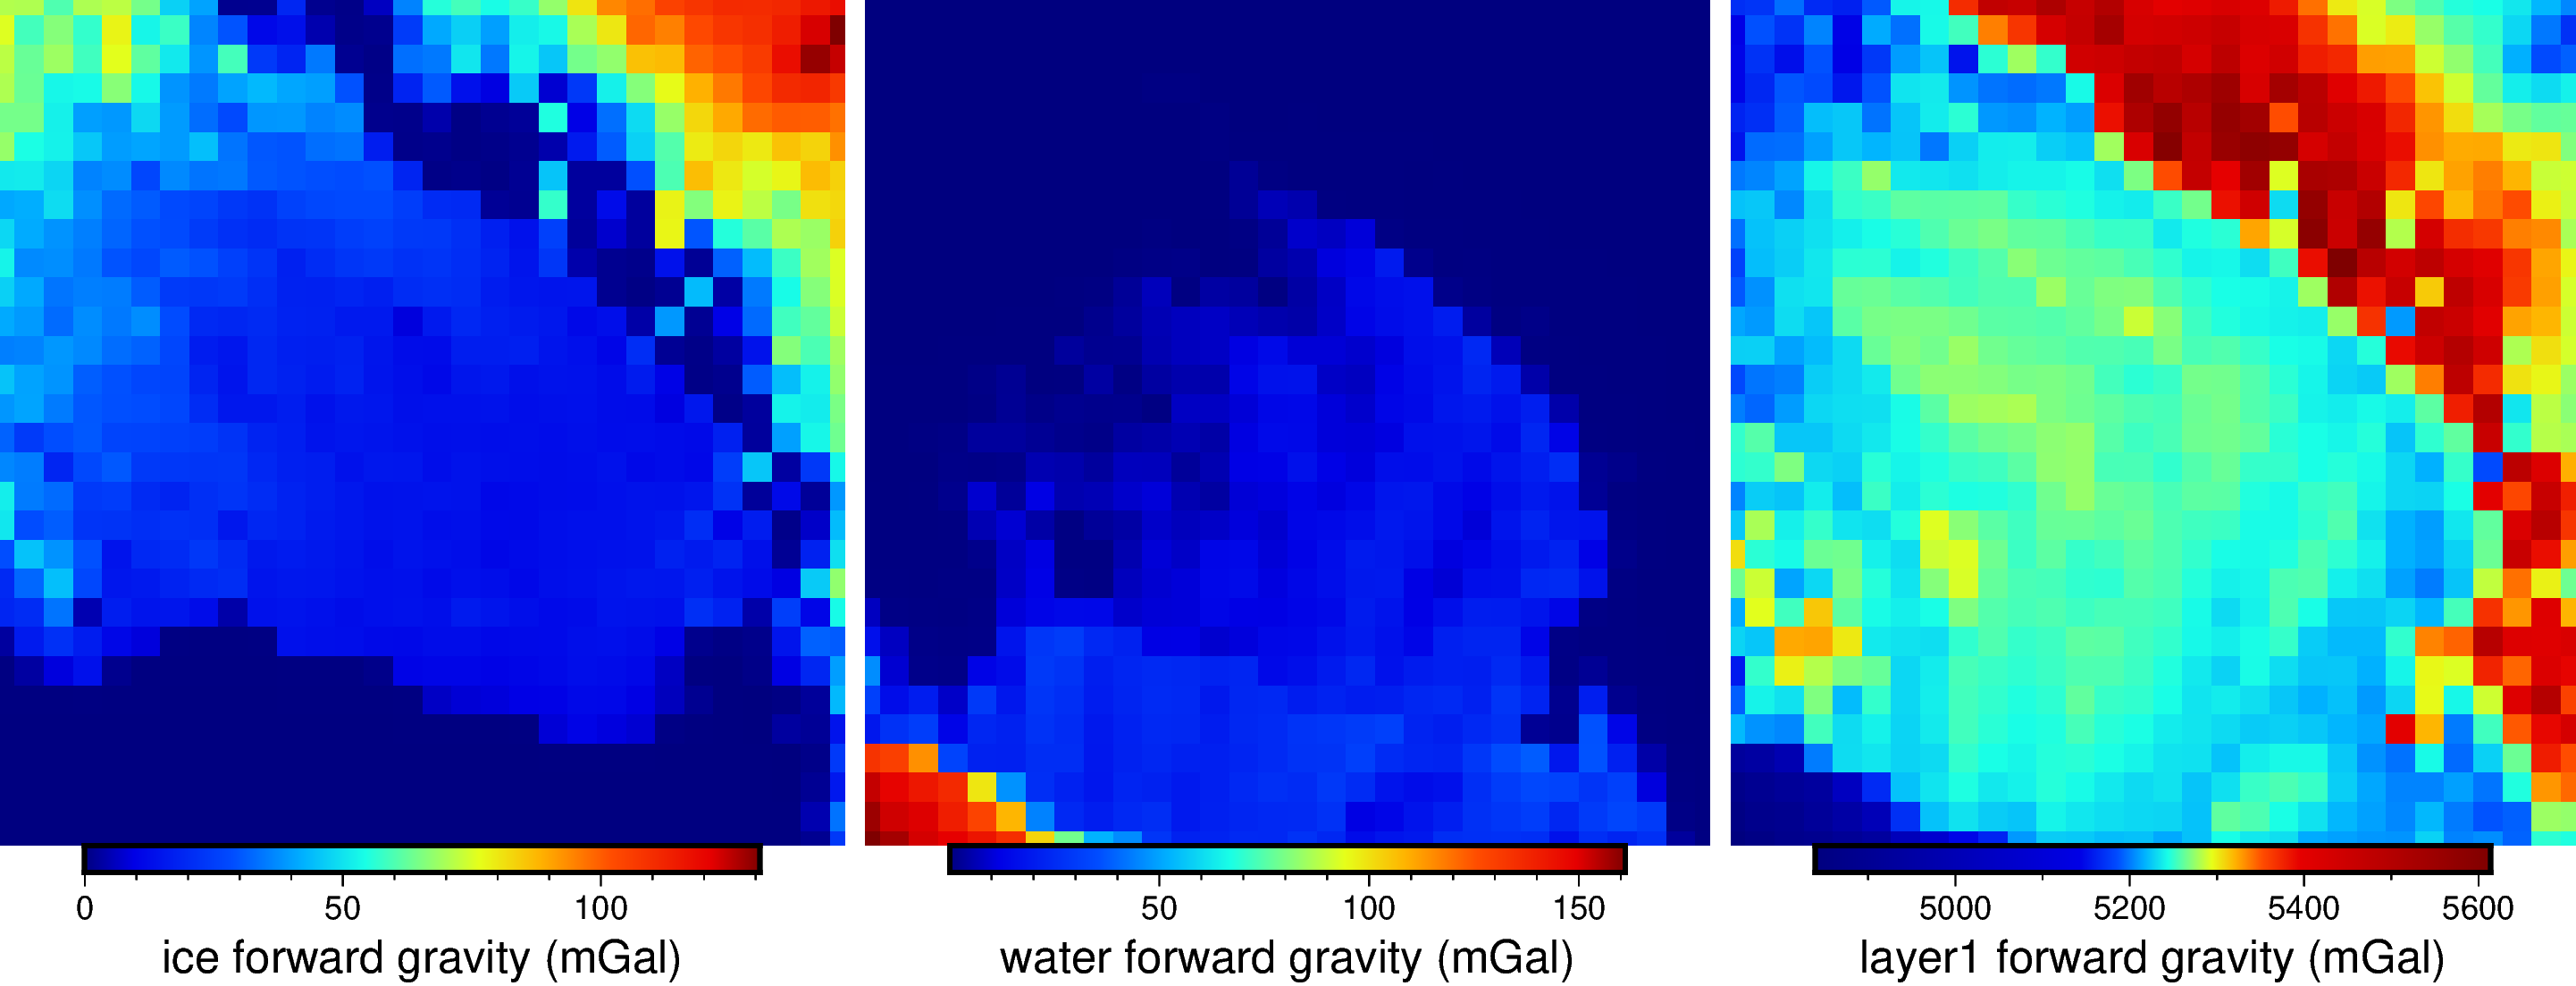

In [10]:
fig = pygmt.Figure()

for i, (k, v) in enumerate(layers.items()):
    data = pygmt.xyz2grd(data=df_grav[['x','y',f'{k}_forward_grav']],
                         region=inv_reg, spacing=grav_spacing, projection=inv_proj) 
    pygmt.grd2cpt(cmap="jet", grid=data, region=fig_reg, background=True, continuous=True)
    fig.grdimage(
        data,
        cmap=True,
        projection=fig_proj, 
        region=fig_reg,
        nan_transparent=True,
        frame=['+gwhite'])
    fig.colorbar(cmap=True, position='jBC+jTC+h', frame=f'x+l"{k} forward gravity (mGal)"')
    
    fig.shift_origin(xshift=(fig_width+2)/10)

    # if i+1 == len(layers)//2:
    #     fig.shift_origin(yshift=(-fig_height-15)/10, xshift=((-fig_width-2)*1)/10)
    # else:
    #     fig.shift_origin(xshift=(fig_width+2)/10)
        
fig.show()

average misfit between Gobs and forward gravity within figure region is -5323 mGal
average Gobs_shifted: 5304 mGal
average forward gravity total: 5304 mGal


psconvert [ERROR]: Registry registered C:\Program Files (x86)\GPLGS\gswin32c.exe does not exist. Resorting to the one provided in GMT.


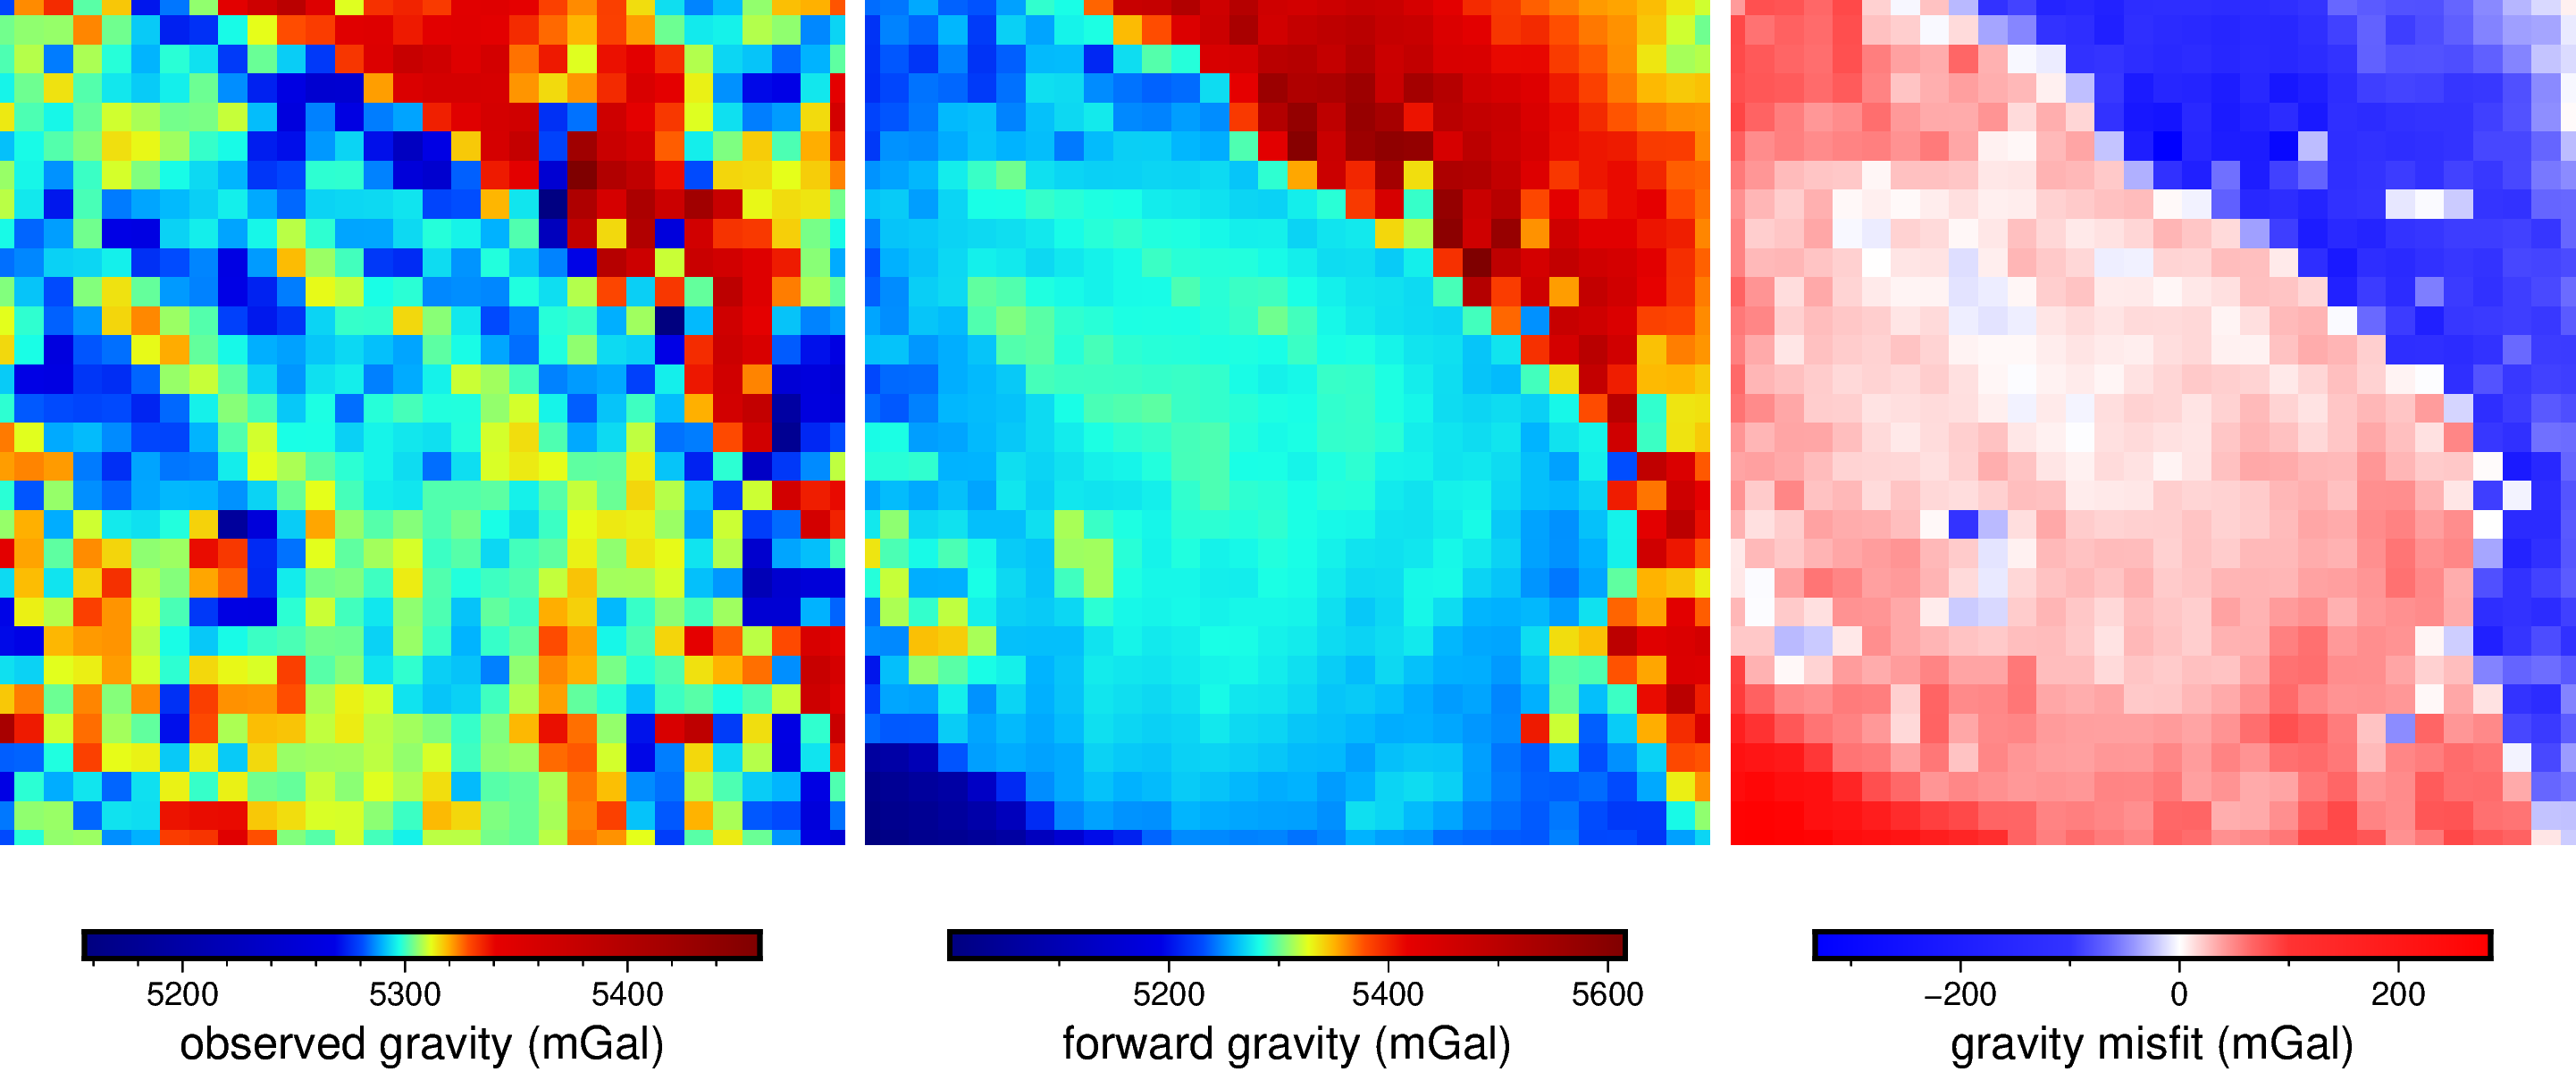

In [11]:
# plot observed, forward, and misfit gravity grids

df_grav['initial_misfit'] = df_grav.Gobs - df_grav.forward_grav_total
shift = df_grav.initial_misfit[(df_grav.x.between(e_fig, w_fig)) & (df_grav.y.between(n_fig, s_fig))].mean() 
print(f'average misfit between Gobs and forward gravity within figure region is {int(shift)} mGal')

df_grav['Gobs_shift'] = df_grav.Gobs - shift
print(f'average Gobs_shifted: {int(df_grav.Gobs_shift[(df_grav.x.between(e_fig, w_fig)) & (df_grav.y.between(n_fig, s_fig))].mean())} mGal')
print(f'average forward gravity total: {int(df_grav.forward_grav_total[(df_grav.x.between(e_fig, w_fig)) & (df_grav.y.between(n_fig, s_fig))].mean())} mGal')

df_grav['forward_grav_misfit'] = df_grav.Gobs_shift - df_grav.forward_grav_total

forward_grav_grid=pygmt.xyz2grd(data = df_grav[['x','y','forward_grav_total']],
                                 region=inv_reg, 
                                 spacing=grav_spacing,
                                 projection=inv_proj)

misfit_grav_grid=pygmt.xyz2grd(data = df_grav[['x','y','forward_grav_misfit']],
                                 region=inv_reg, 
                                 spacing=grav_spacing,
                                 projection=inv_proj)

observed_shift_grav_grid=pygmt.xyz2grd(data = df_grav[['x','y','Gobs_shift']],
                                 region=inv_reg, 
                                 spacing=grav_spacing,
                                 projection=inv_proj)

fig = pygmt.Figure()

# plot observed gravity
grid=observed_shift_grav_grid
pygmt.grd2cpt(cmap="jet", grid=grid, region=fig_reg, background=True, continuous=True)
fig.grdimage(
        grid,
        cmap=True,
        projection=fig_proj, 
        region=fig_reg,
        nan_transparent=True,
        frame=['+gwhite'])
fig.colorbar(cmap=True, frame='af+l"observed gravity (mGal)"')


fig.shift_origin(xshift=(fig_width+2)/10)

# plot forward gravity
grid=forward_grav_grid
pygmt.grd2cpt(cmap="jet", grid=grid, region=fig_reg, background=True, continuous=True)
fig.grdimage(
        grid,
        cmap=True,
        projection=fig_proj, 
        region=fig_reg,
        nan_transparent=True,
        frame=['+gwhite'])
fig.colorbar(cmap=True, frame='af+l"forward gravity (mGal)"')


fig.shift_origin(xshift=(fig_width+2)/10)

# plot misfit gravity
grid=misfit_grav_grid
pygmt.grd2cpt(cmap="polar+h0", grid=grid, region=fig_reg, background=True, continuous=True)
fig.grdimage(
        grid,
        cmap=True,#'polar+h0',
        projection=fig_proj, 
        region=fig_reg,
        nan_transparent=True,
        frame=['+gwhite'])
fig.colorbar(cmap=True, frame='af+l"gravity misfit (mGal)"')


fig.show()

iteration 1


100%|██████████| 2500/2500 [00:22<00:00, 109.08it/s]
psconvert [ERROR]: Registry registered C:\Program Files (x86)\GPLGS\gswin32c.exe does not exist. Resorting to the one provided in GMT.


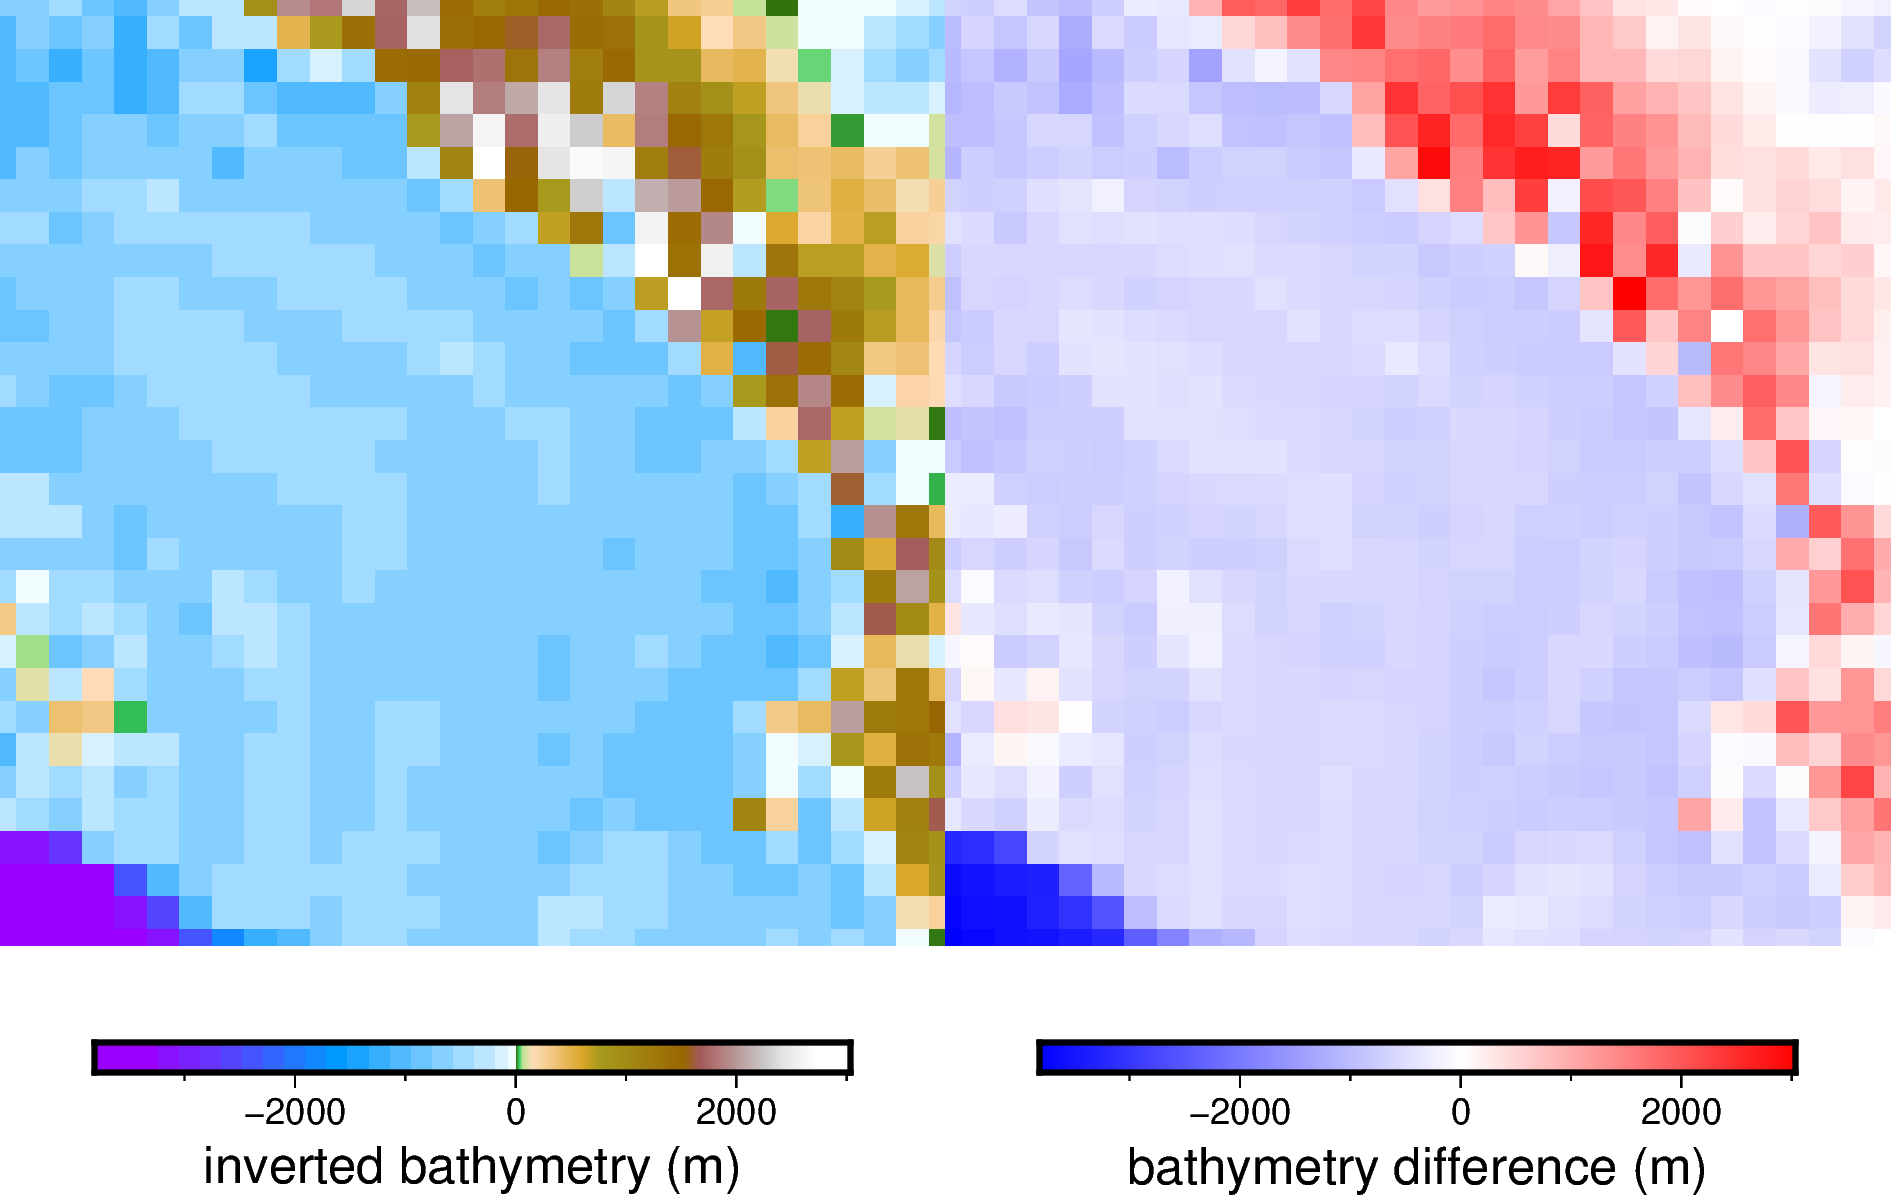

mean of misfit^2 23262176.374901935
misfit_sq_update=23262176.374901935
DCHISQ=inf
Iteration 1 terminated with least-squares norm=23262176.374901935, executing iteration 2
iteration 2


100%|██████████| 2500/2500 [00:25<00:00, 98.06it/s] 
psconvert [ERROR]: Registry registered C:\Program Files (x86)\GPLGS\gswin32c.exe does not exist. Resorting to the one provided in GMT.


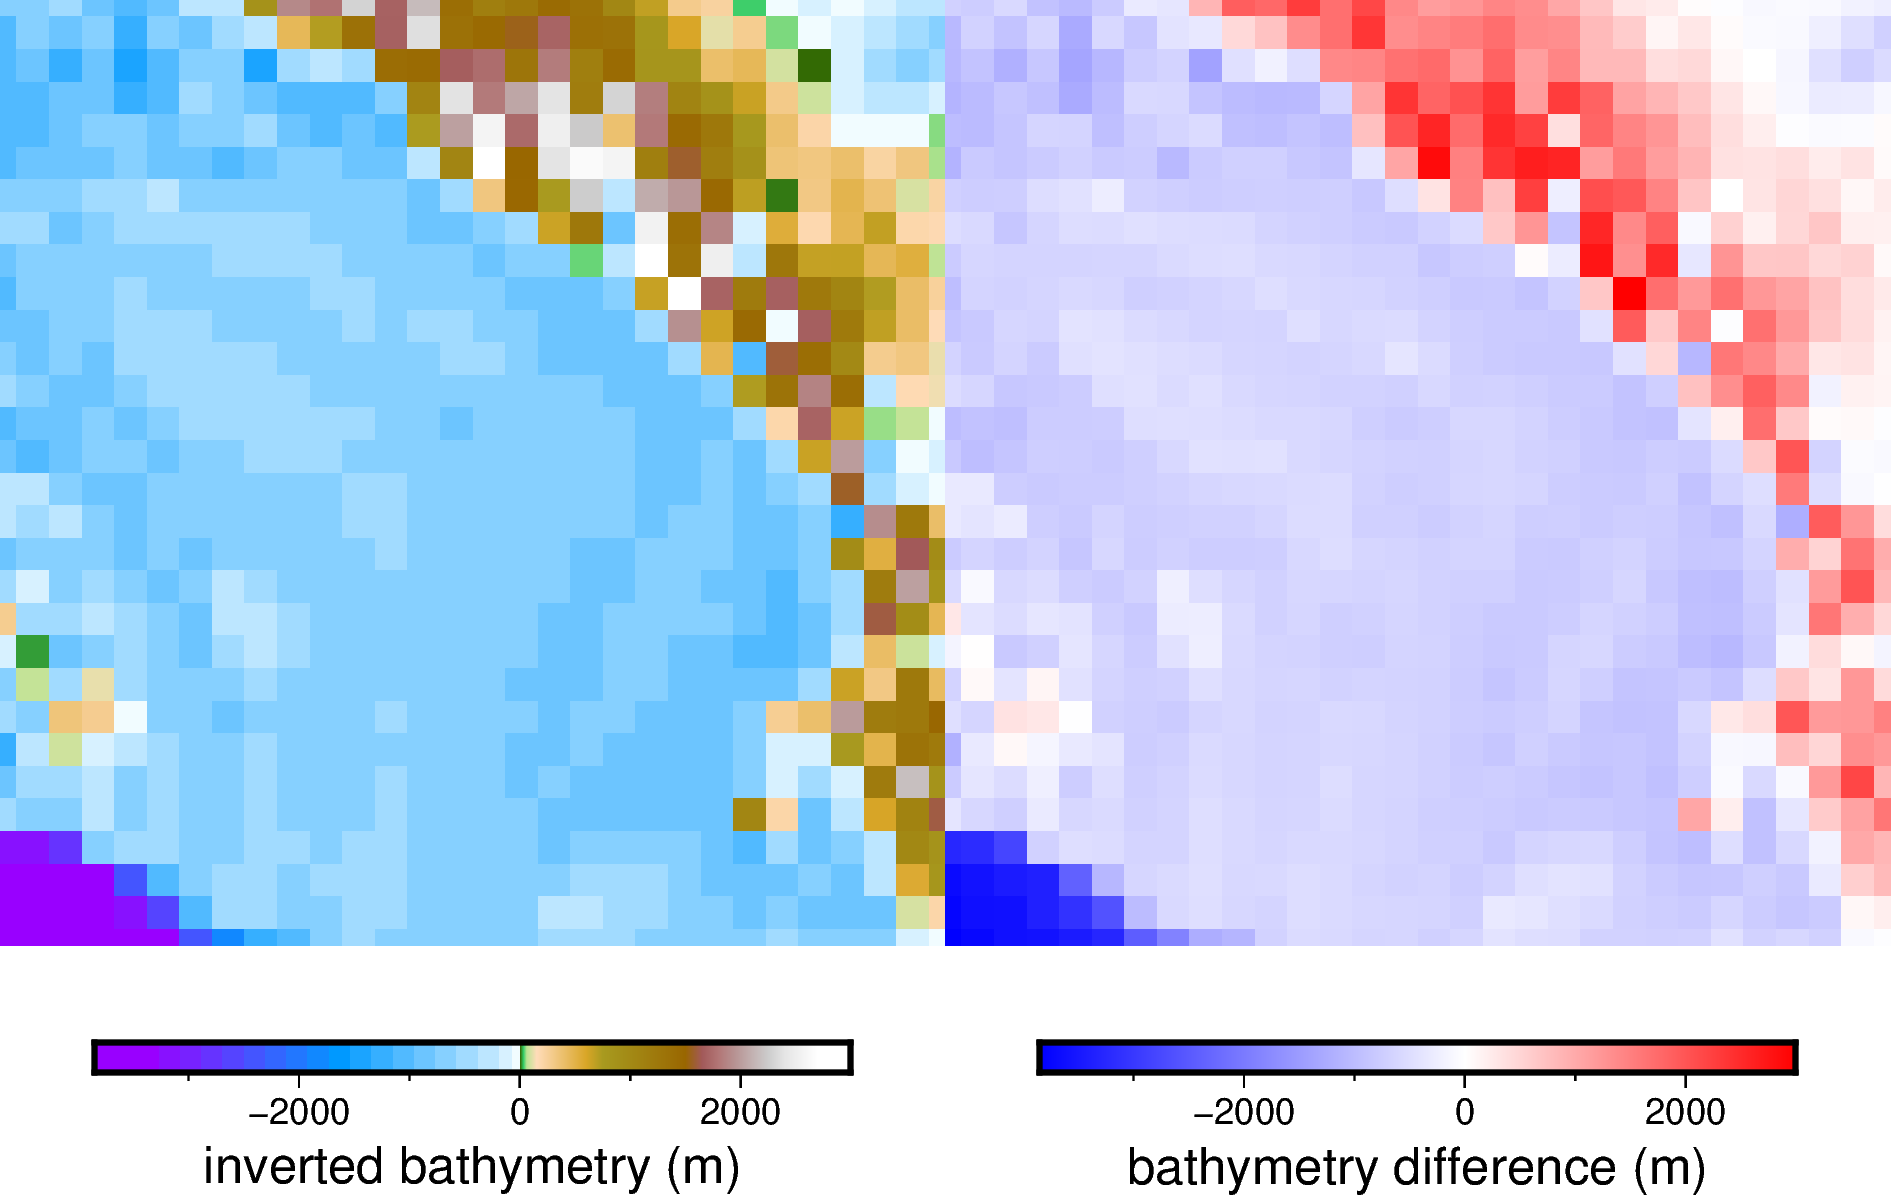

mean of misfit^2 23262176.374901935
misfit_sq_update=23262176.374901935
DCHISQ=1.0
Iteration 2 terminated with least-squares norm=23262176.374901935, executing iteration 3
terminated - no significant variation in least-squares norm 


In [12]:
from scipy.sparse.linalg import lsqr

#########
active_layer = 'layer1'
#########

df = layers[active_layer]['df']
df['z_updated']=df.z
df_grav['grav_inversion']=df_grav.forward_grav_misfit

Tolerance_Least_Square_total=0.01
Tolerance_Least_Squares_iter=0.05
Max_Iterations=4
Tolerance_Bathymetry=20000 

MATDATPAR = (np.zeros([len(df_grav),len(df)])) # array with NG number of rows and NBath+NBase+NM number of columns
MAT_DENS = (np.zeros([len(df_grav),len(df)]))
    
misfit_sq_update=np.Inf  # positive infinity
DCHISQ=np.Inf  # positibe infinity

ITER=0
while DCHISQ > 1+Tolerance_Least_Squares_iter: # while DCHISQ is greater than 1 + least squares tolerance (0.02)
    ITER=ITER+1 
    print(f"iteration {ITER}")
 
    df_grav[f'forward_grav_{ITER}'] = layers[active_layer]['prisms'].prism_layer.gravity(
        coordinates=(df_grav.x, df_grav.y, df_grav.z),
        field = 'g_z',)

    list=pd.Series(reversed_layers_list)
    ind = list[list == active_layer].index[0] - 1

    spacing = layers[active_layer]['spacing'] 
    for i,j in enumerate(tqdm(df_grav.Gobs)):
        # Calculation of the Jacobian matrix using the annular cylinder approximation (grav_column_der)
        #MATDATPAR is matrix array with NG number of rows and NBath+NBase+NM number of columns
        # uses vertical derivative of gravity to find least squares solution to minize gravity misfit for each grav station
        #SURFACE ELEVATION
        MATDATPAR[i,0:len(df)]=grav_column_der(df_grav.y.iloc[i], # coords of gravity observation points
                                               df_grav.x.iloc[i],
                                               df_grav.z.iloc[i],  
                                               df.y, df.x,     
                                               df.z_updated, 
                                               layers[reversed_layers_list[ind]]['grid'].z.to_dataframe().reset_index().z,
                                               spacing,     
                                               df.rho)  # MATDATPAR[i,0:NBath] is i'th row and columns 0 to NBath
    # Calculation of gravity misfit DF, i.e., the difference between calculated and observed gravity
    df_grav[f'inv_misfit_{ITER}']=df_grav.grav_inversion-df_grav[f'forward_grav_{ITER}']

    # gives the amount that each column's Z1 needs to change by to have the smallest misfit
    Surface_correction=lsqr(MATDATPAR,df_grav[f'inv_misfit_{ITER}'],show=False)[0] # finds the least-squares solution to MATDATPAR and Grav_Misfit, assigns the first value to Surface_correction

    # if necesarry correction is greater than tolerance, then correction equals tolerance, if it's less than tolerance, then correct by Surface_correction
    for i in range(0,len(df)):
        if Surface_correction[i] > Tolerance_Bathymetry:
            Surface_correction[i]=Tolerance_Bathymetry
        elif Surface_correction[i] < -Tolerance_Bathymetry:
            Surface_correction[i]=-Tolerance_Bathymetry

    # resetting the Z values with the above corrections 
    df.z_updated=df.z_updated+Surface_correction
    # Z_Corrected_Bathymetry=df.z[0:len(df)]    
    df['z_diff'] = df.z_updated - df.z
    # grid and plot the updated bathymetry, and difference from starting
    layers['layer1']['inv_grid']=pygmt.xyz2grd(df[['x','y','z_updated']], region=inv_reg, spacing=spacing)
    fig = pygmt.Figure()
    data=layers['layer1']['inv_grid']
    fig.grdimage(
            data,
            cmap='globe',
            projection=fig_proj, 
            region=fig_reg,
            nan_transparent=True,
            frame=['+gwhite'])
    fig.colorbar(cmap=True, frame='af+l"inverted bathymetry (m)"')
    fig.shift_origin(xshift=fig_width/10)
    diff = pygmt.xyz2grd(df[['x','y','z_diff']], region=inv_reg, spacing=spacing)
    pygmt.grd2cpt(cmap="polar+h0", grid=diff, region=fig_reg, background=True)
    fig.grdimage(
            data,
            cmap=True,
            projection=fig_proj, 
            region=fig_reg,
            nan_transparent=True,
            frame=['+gwhite'])
    fig.colorbar(cmap=True, frame='af+l"bathymetry difference (m)"')
    fig.show()
    # for first iteration, divide infinity by mean square of gravity residuals, inversion will stop once this gets to Tolerance_Least_Squares_iter (0.02)
    misfit_sq=np.mean(df_grav[f'inv_misfit_{ITER}']**2)
    print(f'mean of misfit^2 {misfit_sq}')
    DCHISQ=misfit_sq_update/misfit_sq
    misfit_sq_update=misfit_sq
    print(f"misfit_sq_update={misfit_sq_update}")
    print(f"DCHISQ={DCHISQ}")
    
    print(f"Iteration {ITER} terminated with least-squares norm={misfit_sq}, executing iteration {ITER+1}")

    # stop the inversion if hit the max # iterations or it's below the Least Squares norm 
    if ITER==Max_Iterations:
        print(f"Inversion terminated after {ITER} iterations with least-squares norm={misfit_sq} because maximum number of iterations {Max_Iterations} reached")
        break
    if misfit_sq < Tolerance_Least_Square_total:
        print(f"Inversion terminated after {ITER} iterations with least-squares norm={misfit_sq} because least-squares norm < {Tolerance_Least_Square_total}")
        break

# end of inversion iteration WHILE loop
if DCHISQ < 1+Tolerance_Least_Squares_iter:
    print("terminated - no significant variation in least-squares norm ")

In [ ]:
# surface = xr.load_dataarray("../inversion_layers/BedMachine_surface_5k_filled.nc")
# icebase = xr.load_dataarray("../inversion_layers/BedMachine_icebase_5k_filled.nc")
# bed = xr.load_dataarray("../inversion_layers/BedMachine_bed_5k.nc")
# basement = xr.load_dataarray("../inversion_layers/ROSETTA_basement_BedMachine_bed.nc", drop_variables='polar_stereographic')
# grav = xr.load_dataset('C:/Users/matthewt/Documents/Python_Scripts/RIS_gravity_inversion/inversion_layers/gravity_inv.nc')

# surface = xr.load_dataset('C:/Users/matthewt/Documents/Python_Scripts/RIS_gravity_inversion/inversion_layers/BedMachine_surface_filled_inv.nc')
# icebase = xr.load_dataset('C:/Users/matthewt/Documents/Python_Scripts/RIS_gravity_inversion/inversion_layers/BedMachine_icebase_filled_inv.nc')
# bed = xr.load_dataset('C:/Users/matthewt/Documents/Python_Scripts/RIS_gravity_inversion/inversion_layers/BedMachine_bed_inv.nc')
# basement = xr.load_dataset('C:/Users/matthewt/Documents/Python_Scripts/RIS_gravity_inversion/inversion_layers/ROSETTA_basement_BedMachine_bed_inv.nc')

# df_grav=grav.to_dataframe().reset_index()
# df_grav.rename(columns={'z':'Gobs'}, inplace=True)
# # df_grav['z']=750
# df_grav['z']=surface.to_dataframe().reset_index().z+750
# df_grav